In [1]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from tqdm.autonotebook import tqdm
#import pandas as pd
import mysql.connector
import codecs
codecs.register(lambda name: codecs.lookup('utf8') if name == 'utf8mb4' else None)
import re
import conllu

In [2]:
db = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd='password',
  #database='commits_db',
  database='pruned_commits_db2',
  charset='utf8mb4')

cur = db.cursor()

In [3]:
def yield_pos_short():
    #mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id LIMIT 1000;')
    cur.execute('SELECT conllu FROM C')
    text = cur.fetchone()
    while text:
        #doc = conllu.parse(text[0])
        doc = re.findall('sent_id', text[0])
        if len(doc) == 1:
            doc = conllu.parse(text[0])
            if len(doc[0].tokens) <= 20:
                yield ' '.join([i['upostag'] for i in doc[0].tokens]), ' '.join([i['deprel'] for i in doc[0].tokens])
        text = cur.fetchone()

In [4]:
file = open('/home/glznv/pos_short_commits2.txt', 'w')
file2 = open('/home/glznv/rel_short_commits2.txt', 'w')
for text in tqdm(yield_pos_short()):
    print(text[0], file=file)
    print(text[1], file=file2)

In [5]:
def yield_2plus_short(first, latter):
    #mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id LIMIT 1000;')
    cur.execute('SELECT conllu FROM C')
    text = cur.fetchone()
    while text:
        #doc = conllu.parse(text[0])
        doc = re.findall('sent_id', text[0])
        if len(doc) > 1:
            doc = conllu.parse(text[0])
            if len(doc[0]) > 1:
                f = ' '.join([i['deprel'] for i in doc[0].tokens])
                s = '\n'.join([' '.join([i['deprel'] for i in d.tokens]) for d in doc[1:]])
                print(f, file=first)
                print(s, file=latter)
                yield 1
        text = cur.fetchone()

In [6]:
first = open('/home/glznv/2plus_0.txt', 'w')
latter = open('/home/glznv/2plus_next.txt', 'w')
for text in tqdm(yield_2plus_short(first, latter)):
    pass

## по сортированному файлу

In [4]:
text = ''
count = 0
file = open('/home/dkbrz/git_commits/count_by_commit.txt','w')
for line in tqdm(open('/home/dkbrz/git_commits/sorted_commits.txt')):
    current = line.strip()
    if current == text:
        count += 1
    else:
        if count > 1:
            print('{}\t{}'.format(count, line), file=file)
        text = current
        count = 1

In [5]:
! sort -g -r /home/dkbrz/git_commits/count_by_commit.txt > /home/dkbrz/git_commits/sorted_count_by_commit.txt

In [6]:
ord('✨')

10024

In [7]:
'✨'.isalpha()

False

In [65]:
emojis = '🚀✨🐛🎉⚠️📝🌴🎨🚨📦🔥⬆️👍🛠🔧📖💄💰👌♻️🚧🦄🔖😄📚💥😊➕🙈💡💯👷😎💎💅🚫✏️🏻😅❤️🏗🏼😢🎸🤖⚡😀🔀🚑😉🆑👾🤔⚡️🙌🛠️🐞☕️🙏🙄👼😱👻💚👀✔️👋🐬💪😬😂👏🆙🌈😭🌐🌐🌟🍺😁🚒➡️💫📄🙂🐳👉😃🐘😞📱🍻❌🤓😳🐕✂️🏽📌🐎😇🚚📜🐶🤦‍♂️✍️🐀❄️🤞🤫😈✌️😓🔍🆕🐣👊🤗🐝😍🤦👕🐜📺🎁🎩🍕🌹🤷‍♂️🐙😆🖍🔒🔔😒📈😡💀🎃📋🍾🐱☀️✈️💬😜🔩💃🎆📃🖌🔪🎳🚮👽🤙💻🐍😕🏄🛀⭐️👮🤘🖼🚜🍿🍇🔮📰🏷😋😩🚿🎊🗑🏁⚙️🤕👯🔐🔡🤠'
emojis = set(emojis)

In [66]:
file = open('/home/dkbrz/git_commits/emoji_indexed.txt','w')
for key, line in tqdm(enumerate(open('/home/dkbrz/git_commits/all_commits.txt'))):
    if len(set(line) & emojis) > 0:
        print('{}\t{}'.format(key, line.rstrip('\n')), file=file)

In [67]:
! wc -l /home/dkbrz/git_commits/emoji_indexed.txt

51964 /home/dkbrz/git_commits/emoji_indexed.txt


## по месяцам (леммы)

In [1]:
import os
import numpy as np
import re
from tqdm.autonotebook import tqdm
from collections import defaultdict

/home/dkbrz/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
PATH = '/home/dkbrz/git_commits/by_month/'
files = os.listdir(PATH)
files.sort()

In [3]:
reg = re.compile('^.*[a-zа-яA-Z0-9].*$')

In [4]:
years = {str(i):i-1999 for i in range(1999, 2020)}
count_years = {key: 0 for key in years}
count = defaultdict(lambda: np.zeros(len(years)))
for file in tqdm(files):
    k = 0
    for line in open(PATH+file):
        words = line.strip().split()
        for word in words:
            if not word.isalpha() and not word.isnumeric() and not re.match(reg, word):
                use = True
                for letter in word:
                    if letter.isalpha() or letter.isnumeric():
                        use = False
                if use:
                    count[word][years[file[:4]]] += 1
        k += len(words)
    count_years[file[:4]] += k

In [5]:
file = open('punct_emo.txt', 'w')
for key in sorted(count, key=lambda x: sum(count[x]), reverse=True):
    print('{}\t{}\t{}'.format(key, '\t'.join(str(i) for i in count[key]), int(sum(count[key]))), file=file)

In [ ]:
count = set()
for key in sorted(count, key=lambda x: sum(count[x]), reverse=True):


In [6]:
count_years

{'1999': 10423409,
 '2000': 5001750,
 '2001': 7093462,
 '2002': 9120736,
 '2003': 10720248,
 '2004': 13784612,
 '2005': 17273498,
 '2006': 22259701,
 '2007': 27436316,
 '2008': 33422393,
 '2009': 45673067,
 '2010': 59400388,
 '2011': 74414502,
 '2012': 100737548,
 '2013': 108847139,
 '2014': 136580541,
 '2015': 166952766,
 '2016': 182919794,
 '2017': 184662363,
 '2018': 154761269,
 '2019': 63406}

## w2v on emoji

In [2]:
import os
import numpy as np
import re
from tqdm.autonotebook import tqdm
from collections import defaultdict

In [2]:
PATH = '/home/dkbrz/git_commits/by_month/'
files = os.listdir(PATH)
files.sort()

In [3]:
emojis = '✨🐛🎉⚠️📝🌴🎨🚨📦🔥⬆️👍🛠🔧📖💄💰👌♻️🚧🦄🔖😄📚💥😊➕🙈💡💯👷😎💎💅🚫✏️🏻😅❤️🏗🏼😢🎸🤖⚡😀🔀🚑😉🆑👾🤔⚡️🙌🛠️🐞☕️🙏🙄👼😱👻💚👀✔️👋🐬💪😬😂👏🆙🌈😭🌐🌐🌟🍺😁🚒➡️💫📄🙂🐳👉😃🐘😞📱🍻❌🤓😳🐕✂️🏽📌🐎😇🚚📜🐶🤦‍♂️✍️🐀❄️🤞🤫😈✌️😓🔍🆕🐣👊🤗🐝😍🤦👕🐜📺🎁🎩🍕🌹🤷‍♂️🐙😆🖍🔒🔔😒📈😡💀🎃📋🍾🐱☀️✈️💬😜🔩💃🎆📃🖌🔪🎳🚮👽🤙💻🐍😕🏄🛀⭐️👮🤘🖼🚜🍿🍇🔮📰🏷😋😩🚿🎊🗑🏁⚙️🤕👯🔐🔡🤠'
emojis = set(emojis)

In [4]:
len(emojis)

181

In [6]:
outp = open('/home/dkbrz/git_commits/emoji_tokenized.txt', 'w')
for file in tqdm(files):
    k = 0
    for line in open(PATH+file):
        if len(set(line)&emojis) > 0:
            print(line.rstrip(), file=outp)

In [42]:
with open('/home/dkbrz/GitHub/Git_Commits/data/punct_emoji_100.txt') as f:
    all_punct_emoji = set([i.strip() for i in f.readlines()])

In [11]:
outp = open('/home/dkbrz/git_commits/puct_emoji_tokenized.txt', 'w')
for file in tqdm(files):
    k = 0
    for line in open(PATH+file):
        if len(set(line.split())&all_punct_emoji) > 0:
            print(line.rstrip(), file=outp)

In [8]:
from gensim.models import Word2Vec, KeyedVectors

In [2]:
w2v = Word2Vec(workers=8, size=300, seed=23, min_count=100)

In [3]:
fname = '/home/dkbrz/git_commits/w2v.txt'
read_from = '/home/dkbrz/git_commits/puct_emoji_tokenized.txt'

In [ ]:
k = 0
w = 0
for line in tqdm(open(read_from), leave=False):
    w += len(line.split())
    k += 1

In [16]:
w, k

(1192093667, 109712151)

In [5]:
w2v.build_vocab(corpus_file=read_from)

In [6]:
w2v.train(total_examples=109712151, total_words=1192093667, corpus_file=read_from, epochs=5)
w2v.wv.save_word2vec_format(fname, binary=False)

In [9]:
w2v.most_similar('🔨', topn=30)

/home/dkbrz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('864370', 0.6342700123786926),
 ('🛠', 0.5593626499176025),
 ('♻️', 0.5426015853881836),
 ('ethutil', 0.5161137580871582),
 ('bisheng', 0.5109307169914246),
 ('☕️', 0.5087130665779114),
 ('vue2', 0.49076223373413086),
 ('RangeInput', 0.4764140546321869),
 (':hammer', 0.4621356427669525),
 ('🎨', 0.4584771692752838),
 ('Chore', 0.4573122262954712),
 ('🔧', 0.45454877614974976),
 ('ScadaWeb', 0.453567236661911),
 ('🏗', 0.45043933391571045),
 ('bulma', 0.447346031665802),
 ('🚧', 0.445270299911499),
 ('fossa', 0.44386500120162964),
 ('atag', 0.4390007257461548),
 ('verdaccio', 0.438517689704895),
 ('代码优化', 0.43749111890792847),
 ('⚡️', 0.43518564105033875),
 ('vue.j', 0.43363258242607117),
 ('💄', 0.43136635422706604),
 ('object.assign', 0.4292186498641968),
 ('davezuko', 0.4291931986808777),
 ('thaiat', 0.4289606213569641),
 ('sassdoc', 0.4278797507286072),
 ('DragDrop', 0.42762380838394165),
 ('WorkflowManager', 0.4269627332687378),
 ('重构', 0.425419420003891)]

In [17]:
emojis = '✨🐛🎉⚠️📝🌴🎨🚨📦🔥⬆️👍🛠🔧📖💄💰👌♻️🚧🦄🔖😄📚💥😊➕🙈💡💯👷😎💎💅🚫✏️🏻😅❤️🏗🏼😢🎸🤖⚡😀🔀🚑😉🆑👾🤔⚡️🙌🛠️🐞☕️🙏🙄👼😱'
emoji_list = list(i for i in emojis if i in w2v)

In [38]:
del emoji_list[4]

In [9]:
fname = '/home/dkbrz/git_commits/w2v.txt'
w2v = KeyedVectors.load_word2vec_format(fname)

In [19]:
w2v[emoji_list]

array([[ 0.89275664, -0.9771429 ,  0.17954372, ..., -0.37635317,
        -1.3328407 , -0.21707453],
       [ 1.2907588 , -0.05571625,  0.65226895, ...,  1.1993257 ,
        -0.2649231 ,  0.25218734],
       [-0.48747796, -0.6738561 ,  0.02082444, ...,  0.2431335 ,
        -0.7310669 ,  0.18412556],
       ...,
       [-0.004308  , -0.12246145, -0.03529505, ...,  0.03885159,
         0.03680814,  0.0140079 ],
       [-0.22283861, -0.03105228, -0.23583402, ...,  0.24067996,
        -0.11466268,  0.28086954],
       [-0.09332228, -0.26033074, -0.08999555, ...,  0.12110756,
        -0.14039265,  0.19083859]], dtype=float32)

In [10]:
from sklearn.decomposition import PCA

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
with open('/home/dkbrz/GitHub/Git_Commits/data/punct_emoji_100.txt') as f:
    all_pe = [i.strip() for i in f.readlines()]

In [58]:
pca = PCA(n_components=2)
pca = pca.fit_transform(w2v[all_pe][:100])

In [59]:
len(all_pe)

1227

In [62]:
short = all_pe[:100]

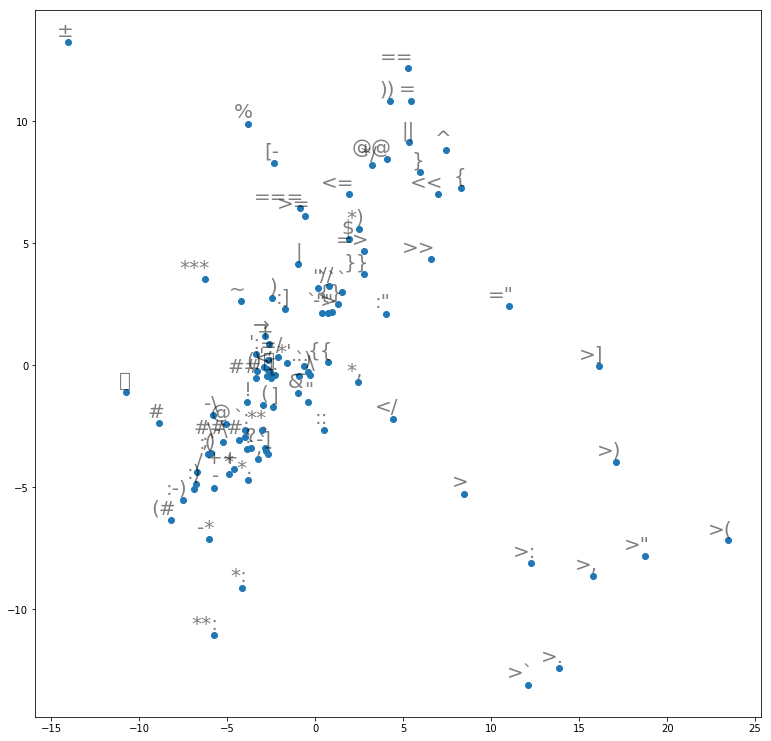

In [64]:
plt.figure(figsize=(13,13))

x, y = [pca[key, 0] for key, word in enumerate(short)], [pca[key, 1] for key, word in enumerate(short)]
labels = [word for word in short]
plt.scatter(x, y)
for i, word in enumerate(labels):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=20)

# Word frequency by month

In [3]:
import os
import numpy as np
import re
from tqdm.autonotebook import tqdm
from collections import defaultdict

In [4]:
PATH = '/home/dkbrz/git_commits/by_month/'
files = os.listdir(PATH)
files.sort()

In [5]:
len(files)

230

In [6]:
counts = np.zeros(230)

cur.execute('SELECT lemma FROM lemmas')
list_of_words = {i[0]:np.zeros(230) for i in cur.fetchall()}

for key, file in tqdm(enumerate(files)):
    k = 0
    for line in open(PATH+file):
        words = line.strip().split()
        for word in words:
            if word in list_of_words:
                list_of_words[word][key] += 1
        k += len(words)
    counts[key] = k

In [7]:
file=open('counts.txt', 'w')
for i in counts:
    print(i, file=file)

In [8]:
file = open('by_month.txt', 'w')
for word in sorted(list_of_words, key=lambda x: sum(list_of_words[x]), reverse=True):
    print('{}\t{}\t{}'.format(word, sum(list_of_words[word]), '\t'.join([str(i) for i in list_of_words[word]])), file=file)

In [9]:
file = open('by_month_IPM.txt', 'w')
for word in sorted(list_of_words, key=lambda x: sum(list_of_words[x]), reverse=True):
    print('{}\t{}'.format(word, '\t'.join([str(i*1000000/counts[key]) for key, i in enumerate(list_of_words[word])])), file=file)

In [10]:
IPM = {word:list_of_words[word]/counts*1000000 for word in list_of_words}

In [11]:
SQRT = {word: np.std(IPM[word][:-3]) for word in IPM}

In [12]:
for word in sorted(SQRT, key=SQRT.get, reverse=True):
    if SQRT[word] > 25:
        print(word, SQRT[word])
    else:
        break

svn 6160.87633560139
git 4862.858612533443
id 4568.443646408983
merge 3432.0414915936462
request 2745.0470378873156
pull 2664.558339818681
from 2313.658689869051
update 2038.566832715145
file 1911.1372243383375
path 1542.1093203567614
info 1536.3841864379747
property 1528.8508658874846
by 1468.1563375258775
the 1461.689014987385
add 1426.2239623162409
fix 1364.1508929046554
kind 1352.7346763994094
to 1259.57294864792
sign 1219.0231579274541
test 1209.4426822853823
off 1202.3565003822735
branch 1161.4959968572014
master 1047.9049049640612
review 940.3873614737803
be 894.3683751299532
in 863.8025057034562
new 858.3357768596796
into 803.7815146228677
trunk 794.5908227752321
for 781.0658333458243
bug 747.013508939917
message 739.7916091273248
likewise 732.0364581203434
commit 659.1847838055712
of 628.0204451577862
issue 618.309045002137
change 617.2633223795549
revision 605.9945593838362
on 599.6013159672077
empty 573.2656741893137
do 524.2375641121109
not 523.8168781329482
and 518.4527882

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

release 310.9076269374276


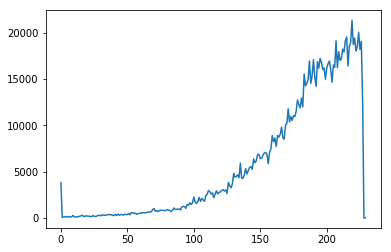

In [24]:
word = 'release'
print(word, SQRT[word])
plt.plot(range(230),list_of_words[word])
plt.show()